In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from tqdm import tqdm_notebook as tqdm
from tcn import TCN
import time
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from keras.preprocessing import sequence
from keras.models import Sequential , load_model , Model
from keras.layers import Dense, Dropout , LSTM , Bidirectional ,GRU ,Flatten,Add,BatchNormalization
from keras_layer_normalization import LayerNormalization
from keras.initializers import  glorot_normal, RandomUniform
from keras import optimizers,Input
from keras_self_attention import SeqSelfAttention
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Using TensorFlow backend.


In [2]:
df = pd.read_csv("Mode2_bike_neighbor.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.set_index("timestamp")
#df.head()

df["hour"] = df.index.hour
df["day_of_month"] = df.index.day
df["day_of_week"]  = df.index.dayofweek
df["month"] = df.index.month

training_data_len = math.ceil(len(df) * 0.9) # taking 90% of data to train and 10% of data to test
testing_data_len = len(df) - training_data_len

time_steps = 24
train, test = df.iloc[0:training_data_len], df.iloc[(training_data_len-time_steps):len(df)]
print(df.shape, train.shape, test.shape)
train_trans = train[['t1','t2', 'hum', 'wind_speed']].to_numpy()
test_trans = test[['t1','t2', 'hum', 'wind_speed']].to_numpy()

scaler = RobustScaler() # Handles outliers
#scaler = MinMaxScaler(feature_range=(0, 1)) # scale to (0,1)
train.loc[:, ['t1','t2','hum', 'wind_speed']]=scaler.fit_transform(train_trans)
test.loc[:, ['t1','t2', 'hum', 'wind_speed']]=scaler.fit_transform(test_trans)

train['cnt'] = scaler.fit_transform(train[['cnt']])
test['cnt'] = scaler.fit_transform(test[['cnt']])

#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in tqdm(range(len(train) - time_steps)):
    x_train.append(train.drop(columns='cnt').iloc[i:i + time_steps].to_numpy())
    y_train.append(train.loc[:,'cnt'].iloc[i + time_steps])

#Convert x_train and y_train to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

#Create the x_test and y_test data sets
x_test = []
y_test = df.loc[:,'cnt'].iloc[training_data_len:len(df)]

for i in tqdm(range(len(test) - time_steps)):
    x_test.append(test.drop(columns='cnt').iloc[i:i + time_steps].to_numpy())
    # y_test.append(test.loc[:,'cnt'].iloc[i + time_steps])

#Convert x_test and y_test to numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

# All 12 columns of the data
print('Train size:')
print(x_train.shape, y_train.shape)
print('Test size:')
print(x_test.shape, y_test.shape)

(735, 16) (662, 16) (97, 16)


C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

  0%|          | 0/638 [00:00<?, ?it/s]

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/73 [00:00<?, ?it/s]

Train size:
(638, 24, 15) (638,)
Test size:
(73, 24, 15) (73,)


In [3]:
from keras.layers import Concatenate
init = glorot_normal(seed=None) # 給 GRU
init_d = RandomUniform(minval=-0.05, maxval=0.05) # 給 Dense layer

def Encoder(layer):
    shortcut = layer
    layer = SeqSelfAttention(
                     attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                     kernel_regularizer=tf.keras.regularizers.l2(0.01),
                     bias_regularizer=tf.keras.regularizers.l2(0.01),
                     attention_regularizer_weight=0.0001)(layer)
    layer = Add()([layer,shortcut])
    layer = LayerNormalization()(layer)
    layer = Flatten()(layer)
    
    shortcut2 = layer
    layer = Dense(16,kernel_initializer=init_d)(layer)
    layer = Dropout(0.5)(layer)
    layer = Concatenate()([layer,shortcut2])
    output = Dense(1,kernel_initializer=init_d)(layer)
    return output

def Decoder(layer):
    shortcut = layer
    layer = SeqSelfAttention(
                     attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                     kernel_regularizer=tf.keras.regularizers.l2(0.01),
                     bias_regularizer=tf.keras.regularizers.l2(0.01),
                     attention_regularizer_weight=0.0001)(layer)
    layer = Add()([layer,shortcut])
    layer = LayerNormalization()(layer)
    layer = SeqSelfAttention(
                     attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                     kernel_regularizer=tf.keras.regularizers.l2(0.01),
                     bias_regularizer=tf.keras.regularizers.l2(0.01),
                     attention_regularizer_weight=0.0001)(layer)
    layer = LayerNormalization()(layer)
    
    layer = Flatten()(layer)
    shortcut2 = layer
    layer = Dense(16,kernel_initializer=init_d)(layer)
    layer = Dropout(0.25)(layer)
    layer = Concatenate()([layer,shortcut2])
    output = Dense(1,kernel_initializer=init_d)(layer)
    return output

def Bi_GRU(layer,unit):
    output = Bidirectional(GRU(unit, dropout=0.25, recurrent_dropout=0.25, return_sequences=True,
                            kernel_initializer=init))(layer)
    return output

#start = Input(shape = (x_train.shape[1],x_train.shape[2]))
start = Input(shape = (x_train.shape[1:]))
start2 = Input(shape = (x_train.shape[1:]))
x = Bi_GRU(start,32)
x = Encoder(x)

y = Bi_GRU(start2,16)
y = Decoder(y)

Merge = Add()([x,y])
Last = Dense(1)(Merge)
model = Model([start,start2] , Last)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 24, 15)       0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 24, 32)       3072        input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 24, 15)       0                                            
__________________________________________________________________________________________________
seq_self_attention_2 (SeqSelfAt (None, 24, 32)       1025        bidirectional_2[0][0]            
____________________________________________________________________________________________

Train...
Train on 574 samples, validate on 64 samples
Epoch 1/500
574/574 [==============================] - 4s 7ms/step - loss: 2.7518 - val_loss: 6.7304
Epoch 2/500
574/574 [==============================] - 2s 3ms/step - loss: 2.0012 - val_loss: 2.5922
Epoch 3/500
574/574 [==============================] - 2s 3ms/step - loss: 1.9105 - val_loss: 3.7887
Epoch 4/500
574/574 [==============================] - 2s 3ms/step - loss: 1.9059 - val_loss: 1.9763
Epoch 5/500
574/574 [==============================] - 2s 3ms/step - loss: 1.8086 - val_loss: 3.0070
Epoch 6/500
574/574 [==============================] - 2s 3ms/step - loss: 1.7480 - val_loss: 2.2661
Epoch 7/500
574/574 [==============================] - 2s 3ms/step - loss: 1.6892 - val_loss: 1.9823
Epoch 8/500
574/574 [==============================] - 2s 3ms/step - loss: 1.6537 - val_loss: 2.9850
Epoch 9/500
574/574 [==============================] - 2s 3ms/step - loss: 1.5819 - val_loss: 3.0344
Epoch 10/500
574/574 [===============

Epoch 81/500
574/574 [==============================] - 2s 3ms/step - loss: 0.7054 - val_loss: 2.7745
Epoch 82/500
574/574 [==============================] - 2s 3ms/step - loss: 0.6733 - val_loss: 2.3700
Epoch 83/500
574/574 [==============================] - 2s 3ms/step - loss: 0.6786 - val_loss: 3.4513
Epoch 84/500
574/574 [==============================] - 2s 3ms/step - loss: 0.6905 - val_loss: 3.4240
Epoch 85/500
574/574 [==============================] - 2s 3ms/step - loss: 0.6719 - val_loss: 2.9689
Epoch 86/500
574/574 [==============================] - 2s 3ms/step - loss: 0.6755 - val_loss: 2.7325
Epoch 87/500
574/574 [==============================] - 2s 3ms/step - loss: 0.6867 - val_loss: 3.9516
Epoch 88/500
574/574 [==============================] - 2s 3ms/step - loss: 0.6674 - val_loss: 4.0855
Epoch 89/500
574/574 [==============================] - 2s 3ms/step - loss: 0.6720 - val_loss: 2.8588
Epoch 90/500
574/574 [==============================] - 2s 3ms/step - loss: 0.6601

574/574 [==============================] - 2s 3ms/step - loss: 0.2610 - val_loss: 0.8484
Epoch 240/500
574/574 [==============================] - 2s 3ms/step - loss: 0.2524 - val_loss: 0.8448
Epoch 241/500
574/574 [==============================] - 2s 3ms/step - loss: 0.2649 - val_loss: 0.8111
Epoch 242/500
574/574 [==============================] - 2s 3ms/step - loss: 0.2586 - val_loss: 0.7375
Epoch 243/500
574/574 [==============================] - 2s 3ms/step - loss: 0.2483 - val_loss: 0.7612
Epoch 244/500
574/574 [==============================] - 2s 3ms/step - loss: 0.2539 - val_loss: 0.7465
Epoch 245/500
574/574 [==============================] - 2s 3ms/step - loss: 0.2629 - val_loss: 0.7671
Epoch 246/500
574/574 [==============================] - 2s 3ms/step - loss: 0.2664 - val_loss: 0.7045
Epoch 247/500
574/574 [==============================] - 2s 3ms/step - loss: 0.2629 - val_loss: 0.7829
Epoch 248/500
574/574 [==============================] - 2s 3ms/step - loss: 0.2448 - v

574/574 [==============================] - 2s 3ms/step - loss: 0.1572 - val_loss: 0.9496
Epoch 398/500
574/574 [==============================] - 2s 3ms/step - loss: 0.1722 - val_loss: 0.6345
Epoch 399/500
574/574 [==============================] - 2s 3ms/step - loss: 0.1767 - val_loss: 0.8043
Epoch 400/500
574/574 [==============================] - 2s 3ms/step - loss: 0.1688 - val_loss: 0.5725
Epoch 401/500
574/574 [==============================] - 2s 3ms/step - loss: 0.1806 - val_loss: 0.6897
Epoch 402/500
574/574 [==============================] - 2s 3ms/step - loss: 0.1502 - val_loss: 0.6951
Epoch 403/500
574/574 [==============================] - 2s 3ms/step - loss: 0.1550 - val_loss: 0.5739
Epoch 404/500
574/574 [==============================] - 2s 3ms/step - loss: 0.1589 - val_loss: 0.6076
Epoch 405/500
574/574 [==============================] - 2s 3ms/step - loss: 0.1677 - val_loss: 0.6745
Epoch 406/500
574/574 [==============================] - 2s 3ms/step - loss: 0.1708 - v

Predict time:  0.5053224563598633
RMSE2:  9.243014380770873
MAE2:  6.646703983236053
R-square2:  -0.6148710470090661


Text(0, 0.5, 'mse score')

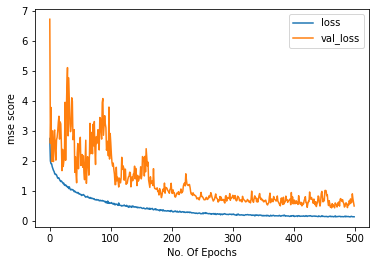

In [4]:
opt = optimizers.Adam(lr=0.0009)
print('Train...')
model.compile(optimizer = opt , loss="mse")
#model.compile(optimizer = "adam" , loss="mse")
history = model.fit([x_train,x_train], y_train, epochs = 500, batch_size=24, validation_split=0.1, shuffle=True)
# history = model.fit(x_train, y_train, epochs = 500, batch_size=6, validation_split=0.1, shuffle=True)
model.summary()
#Save Model
model.save('GRU_Single_Attention_model_neighbor.h5')  # creates a HDF5 file 
del model

custom_ob = {'LayerNormalization': LayerNormalization , 'SeqSelfAttention':SeqSelfAttention}
model = load_model('GRU_Single_Attention_model_neighbor.h5', custom_objects=custom_ob)
t1 = time.time()
y_pred2 = model.predict([x_test,x_test])
#y_pred2 = model.predict(x_test)
#y_pred = model.predict(x_train)
t2 = time.time()
print('Predict time: ',t2-t1)
y_pred = scaler.inverse_transform(y_pred2)#Undo scaling
rmse_lstm2 = np.sqrt(mean_squared_error(y_test, y_pred2))
#rmse_lstm = np.sqrt(mean_squared_error(y_train, y_pred))
#print('RMSE: ',rmse_lstm)
print('RMSE2: ',rmse_lstm2)
mae2 = mean_absolute_error(y_test, y_pred2)
#mae = mean_absolute_error(y_train, y_pred)
#print('MAE: ',mae)
print('MAE2: ',mae2)
r22 =  r2_score(y_test, y_pred2)
# r2 =  r2_score(y_train, y_pred)
# print('R-square: ',r2)
print('R-square2: ',r22)

# n = len(y_test)
# p = 12
# Adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
# Adj_r22 = 1-(1-r22)*(n-1)/(n-p-1)
# print('Adj R-square: ',Adj_r2)
# print('Adj R-square2: ',Adj_r22)

plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")